In [1]:
import pickle
import pandas as pd
# Define the path to the .pkl file
input_path = "/data/sr933/scRCC/combined_data/RCC_data_dict.pkl"

# Load the dictionary from the .pkl file
with open(input_path, "rb") as f:
    data_dict = pickle.load(f)

# Access the contents of the dictionary
X_combined = data_dict["X"].T
y_labels = data_dict["y"]
gene_list = data_dict["Genes"]

df = pd.read_csv('/home/sr933/rcc/4_network_analysis/data/key_proteins_muanually_filtered.txt')

# Convert the 'Genes' column to a list
target_genes_list = df['Gene'].tolist()
# Get indices of elements in sublist from main_list
indices = [i for i, element in enumerate(gene_list) if element in target_genes_list]

# Select columns based on indices
filtered_X_train = X_combined[:, indices]
#y_labels[y_labels >= 1] = 1

In [2]:
pickle_file_path = "/data/sr933/scRCC validation/processed data/scRCC_validation_dataset_lithuanian.pkl"

# Load the pickle file
with open(pickle_file_path, "rb") as pkl_file:
    loaded_validation_data = pickle.load(pkl_file)
    

df = pd.read_csv('/home/sr933/rcc/data/Target_genes.csv')

# Convert the 'Genes' column to a list
target_genes_list_all = df['Genes'].tolist()  
indices=[i for i, element in enumerate(target_genes_list_all) if element in target_genes_list]
X_test_china=loaded_validation_data["X_test"].T

y_test_china=loaded_validation_data["y_test"]
X_test_china = X_test_china[:, indices]
y_test_china_labels=y_test_china
y_test_china = [0 if label == 'Tumor cells' else 1 for label in y_test_china]
print(X_test_china.shape)

(50236, 16)


# UMAP of new dataset

In [3]:
import umap
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Initialize and fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Step 2: Transform the data
X_umap = reducer.fit_transform(X_test_china)

/home/sr933/miniconda3/envs/rcc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sr933/miniconda3/envs/rcc/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


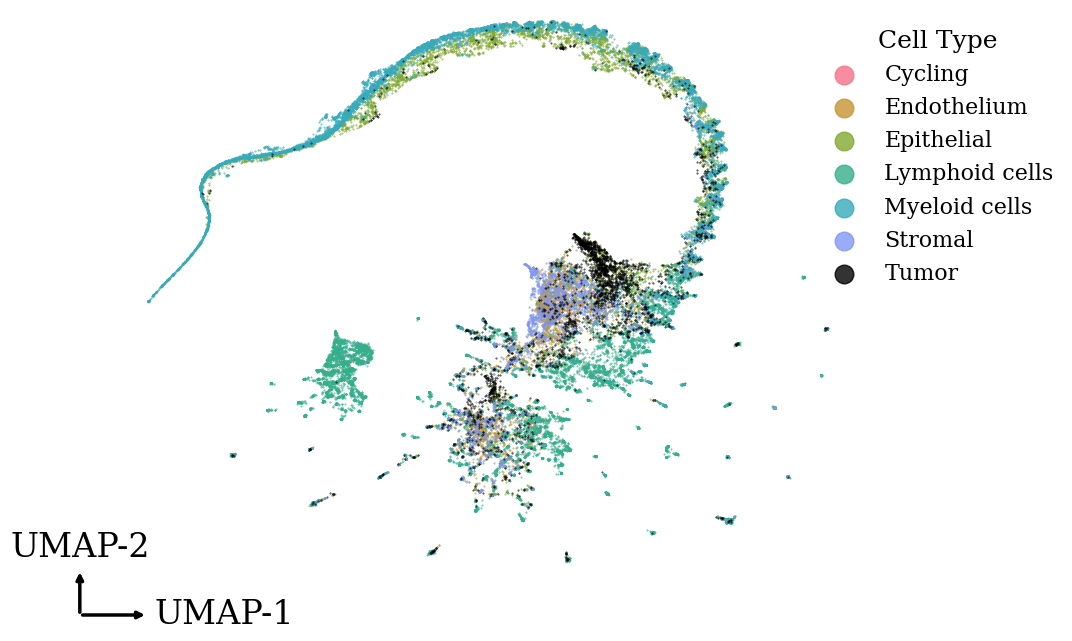

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Update plot styling for publication
params = {
    "ytick.color": "black",
    "xtick.color": "black",
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
}
plt.rcParams.update(params)

# Define and sort unique targets
targets = sorted(set(y_test_china_labels))
num_targets = len(targets)
colors = sns.color_palette("husl", num_targets)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot non-tumor cells
for i, target in enumerate(targets):
    if target == "Tumor cells":
        continue
    mask = np.array(y_test_china_labels) == target
    ax.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        c=[colors[i]],
        label=target,
        s=0.2,
        alpha=0.8
    )

# Plot tumor cells in black
mask = np.array(y_test_china_labels) == "Tumor cells"
ax.scatter(
    X_umap[mask, 0],
    X_umap[mask, 1],
    c="k",
    label="Tumor",
    s=0.2,
    alpha=0.8
)

# Legend formatting
ax.legend(
    title="Cell Type",
    fontsize=16,
    markerscale=30,
    loc="upper right",
    frameon=False,
    title_fontsize=18,
    bbox_to_anchor=(1.3, 1.0)
)

# Turn off axis lines
ax.axis("off")

# Arrow setup: UMAP axes in bottom-left corner
min_x, min_y = X_umap[:, 0].min(), X_umap[:, 1].min()
range_x = X_umap[:, 0].max() - min_x
range_y = X_umap[:, 1].max() - min_y

arrow_len_x = 0.1 * range_x
arrow_len_y = 0.1 * range_x  # uniform scale

x_pad = 0.1 * range_x
y_pad = 0.1 * range_y
arrow_base_x = min_x - x_pad
arrow_base_y = min_y - y_pad

# Draw arrows
ax.annotate("", xy=(arrow_base_x + arrow_len_x, arrow_base_y), xytext=(arrow_base_x, arrow_base_y),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2.5))
ax.annotate("", xy=(arrow_base_x, arrow_base_y + arrow_len_y), xytext=(arrow_base_x, arrow_base_y),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2.5))

# Axis labels
ax.text(arrow_base_x + arrow_len_x + 0.01 * range_x, arrow_base_y, "UMAP-1", fontsize=24, ha="left", va="center")
ax.text(arrow_base_x, arrow_base_y + arrow_len_y + 0.01 * range_y, "UMAP-2", fontsize=24, ha="center", va="bottom")

# Adjust limits to show arrows
ax.set_xlim(arrow_base_x - 0.02 * range_x, X_umap[:, 0].max() + 0.02 * range_x)
ax.set_ylim(arrow_base_y - 0.02 * range_y, X_umap[:, 1].max() + 0.02 * range_y)

# Save plot
save_path = "/home/sr933/output/umap_lithuania_drug_targets.png"
plt.savefig(save_path, format="png", bbox_inches="tight", dpi=900)
plt.show()


# Classifier

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb


# Load the trained Booster
booster = lgb.Booster(model_file='/home/sr933/rcc/data/lgbm_model_reduced.txt')

# Step 4: Make predictions using the Booster directly
y_pred_prob = booster.predict(X_test_china)

# Step 5: Evaluate the model
prob_dict = {"True": y_test_china, "Predicted": y_pred_prob}
df = pd.DataFrame(prob_dict)
df.to_csv('/home/sr933/rcc/data/predicted_prob_lithuanian_drug.csv', index=False)



[[ 2226   813]
 [  171 47026]]
Area Under the Curve (AUC): 0.8644273385539233


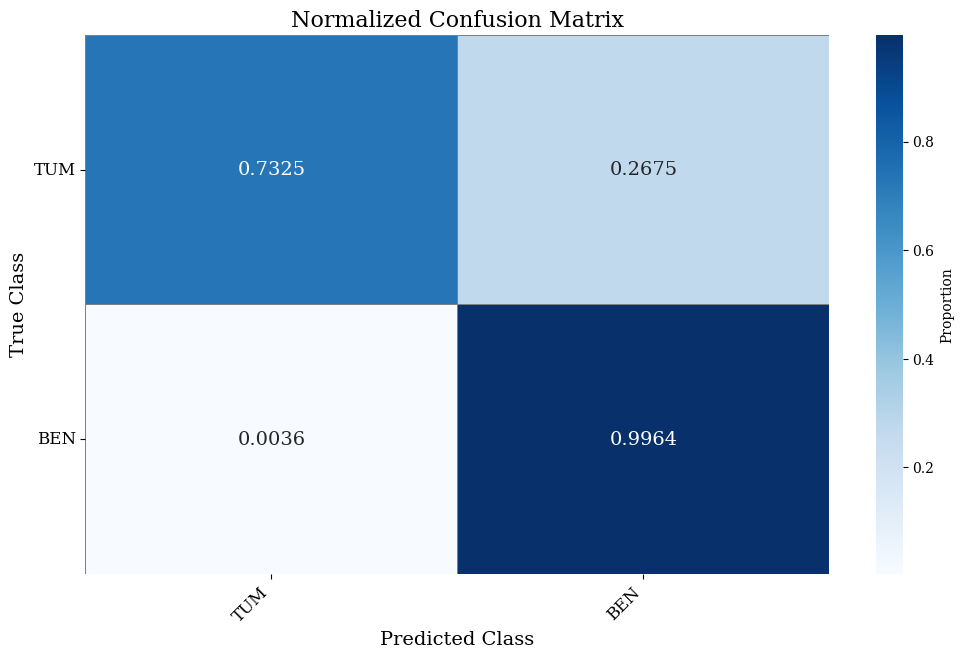

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_pred=[0 if prob<0.5 else 1 for prob in y_pred_prob]
cm = confusion_matrix(y_test_china, y_pred)
print(cm)
classes=["TUM", "BEN"]
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index=classes, columns=classes)

plt.figure(figsize = (12,7))
# Create the heatmap with additional customization
sn.heatmap(df_cm, annot=True, fmt=".4f", cmap="Blues", linewidths=0.5, linecolor='gray', 
            cbar_kws={'label': 'Proportion'}, annot_kws={"size": 14})

# Axis labels and title
plt.ylabel("True Class", fontsize=14)
plt.xlabel("Predicted Class", fontsize=14)
plt.title("Normalized Confusion Matrix", fontsize=16)

# Ensure that axis labels are clearly visible
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

from sklearn.metrics import roc_auc_score

# Calculate AUC
auc = roc_auc_score(y_test_china, y_pred)

print(f"Area Under the Curve (AUC): {auc}")